对比AVISO和模式数据的去除气候态的海表高度异常(相关系数， 标准差)

In [4]:
import numpy as np
from PyEMD import EMD, Visualisation, EEMD
import matplotlib.pyplot as plt
import matplotlib as mpt
import matplotlib.colors as mcolors
from matplotlib import ticker  
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
import hvplot.xarray
import pandas as pd 
import xarray as xr
import xeofs as xe
import cartopy.mpl.ticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from scipy.io import loadmat, savemat
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import detrend, hilbert, welch, find_peaks, correlate
from scipy.ndimage import gaussian_filter
from eofs.standard import Eof
from scipy.stats import chi2, pearsonr
from pykalman import KalmanFilter
plt.rcParams['font.family'] = 'Times New Roman'
mpt.rcParams['axes.unicode_minus']=False
np.set_printoptions(suppress=True)
# font={'family':'SimHei',
#     'weight':'bold'}
# mpt.rc('font',**font)

%matplotlib inline
# %matplotlib qt
%pwd

'e:\\public_for_GitHub\\indian_ocean_data_process'

## 计算逐点相关，并作显著性检验

In [5]:
import xarray as xr
import numpy as np
from scipy.stats import pearsonr

def xr_pearsonr(data1, data2, dim='time'):
    """
    计算两个xarray DataArray的Pearson相关系数，忽略NaN值。
    """
    def _pearsonr_nan(x, y):
        # 提取有效数据点（两者均非NaN）
        valid = ~np.isnan(x) & ~np.isnan(y)
        x_valid = x[valid]
        y_valid = y[valid]
        if len(x_valid) < 2:
            return np.nan, np.nan  # 数据不足无法计算
        return pearsonr(x_valid, y_valid)
    
    corr, p_value = xr.apply_ufunc(
        _pearsonr_nan,
        data1,
        data2,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], []],
        vectorize=True,  # 自动遍历非核心维度（如lat、lon）
        output_dtypes=[float, float]
    )
    
    return corr, p_value


detrended_model_SLA = xr.open_dataarray(r'D:\monthly_mean\model_SLA_data\model_detrended_SLA.nc')
detrended_AVISO_SLA = xr.open_dataarray(r'D:\AVISO_SLA_copernicusmarine\AVISO_SLA_data\AVISO_detrended_SLA.nc')
corr, p_value = xr_pearsonr(detrended_model_SLA, detrended_AVISO_SLA)

## 绘制空间相关

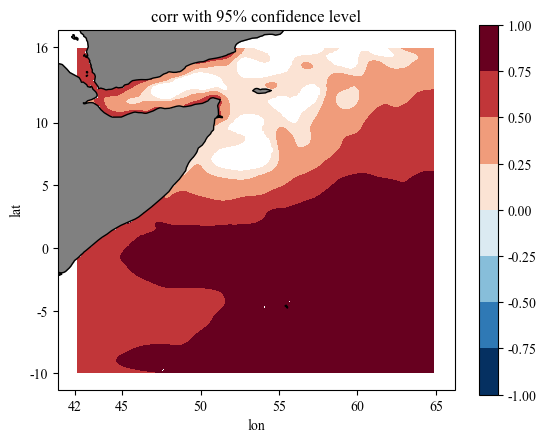

In [6]:
valid_corr = corr.where(p_value<0.05)
valid_corr.plot.contourf(x='lon', subplot_kws=dict(projection=ccrs.PlateCarree()), levels=10, cmap='RdBu_r')
ax = plt.gca()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, color='gray')
ax.set_aspect(0.8)
plt.xticks([42, *np.arange(45, 65.1, 5)])
plt.yticks([*np.arange(-10, 15, 5), 16])

plt.title(r'corr with 95% confidence level')
plt.savefig(r'C:\Users\Admin\Desktop\eddy_figs\corr_model&AVISO.jpg', dpi=500)

## 绘制标准差

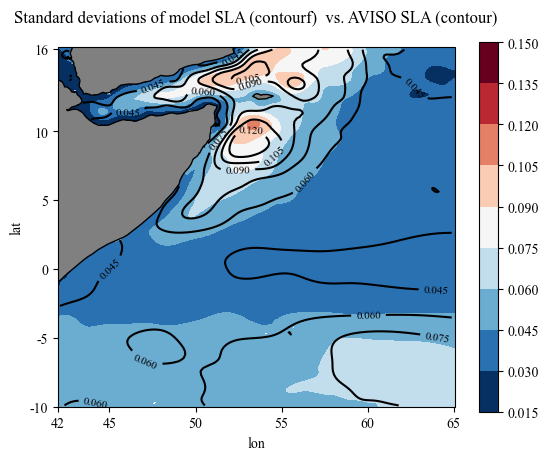

In [7]:
detrended_model_SLA.std(dim='time').plot.contourf(x='lon', subplot_kws=dict(projection=ccrs.PlateCarree()), 
                                                  levels=np.arange(0.015, 0.151, 0.015), cmap='RdBu_r')
ax = plt.gca()
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, color='gray')
h = ax.contour(detrended_AVISO_SLA.lon.values, detrended_AVISO_SLA.lat.values, 
           detrended_AVISO_SLA.std(dim='time'), transform=ccrs.PlateCarree(), colors='k', 
           levels=np.arange(0.015, 0.151, 0.015))
plt.clabel(h, inline=True, fontsize=8, colors='k' )
ax.set_aspect(0.8)
plt.xticks([42, *np.arange(45, 65.1, 5)])
plt.yticks([*np.arange(-10, 15, 5), 16])
plt.title(r'Standard deviations of model SLA (contourf)  vs. AVISO SLA (contour)', y=1.05)
plt.savefig(r'C:\Users\Admin\Desktop\eddy_figs\std_model&AVISO.jpg', dpi=500)

对比气候态

c:\Users\Admin\anaconda3\envs\xeofs\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Admin\anaconda3\envs\xeofs\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Admin\anaconda3\envs\xeofs\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Admin\anaconda3\envs\xeofs\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\Admin\anaconda3\envs\xeofs\Lib\site-packages\cartopy\mpl\feature_ar

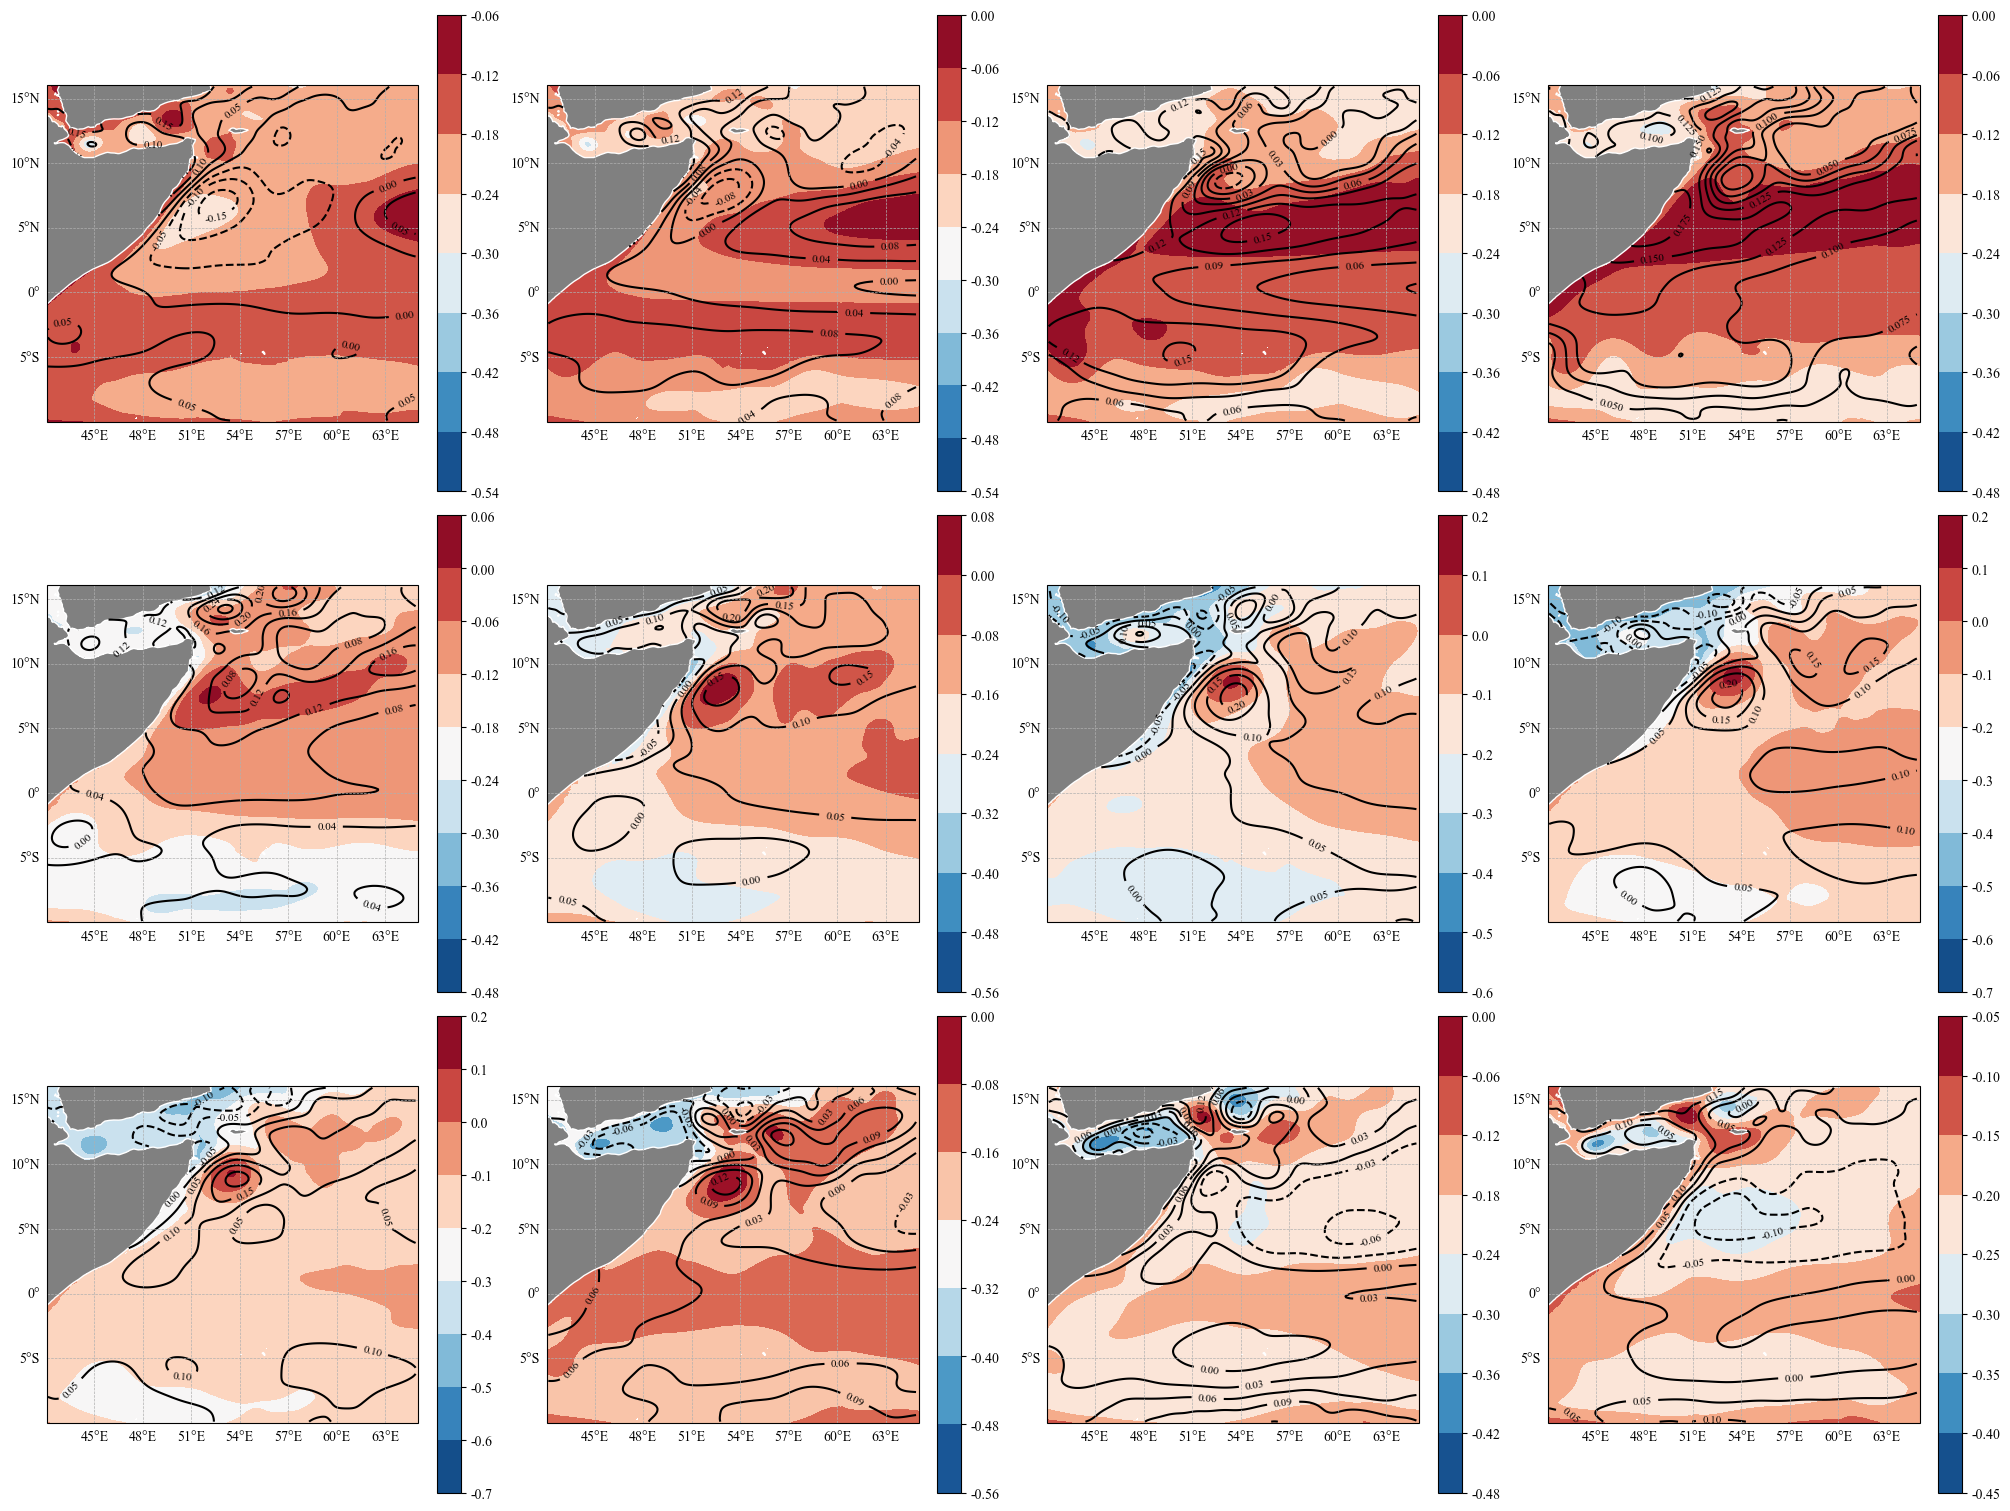

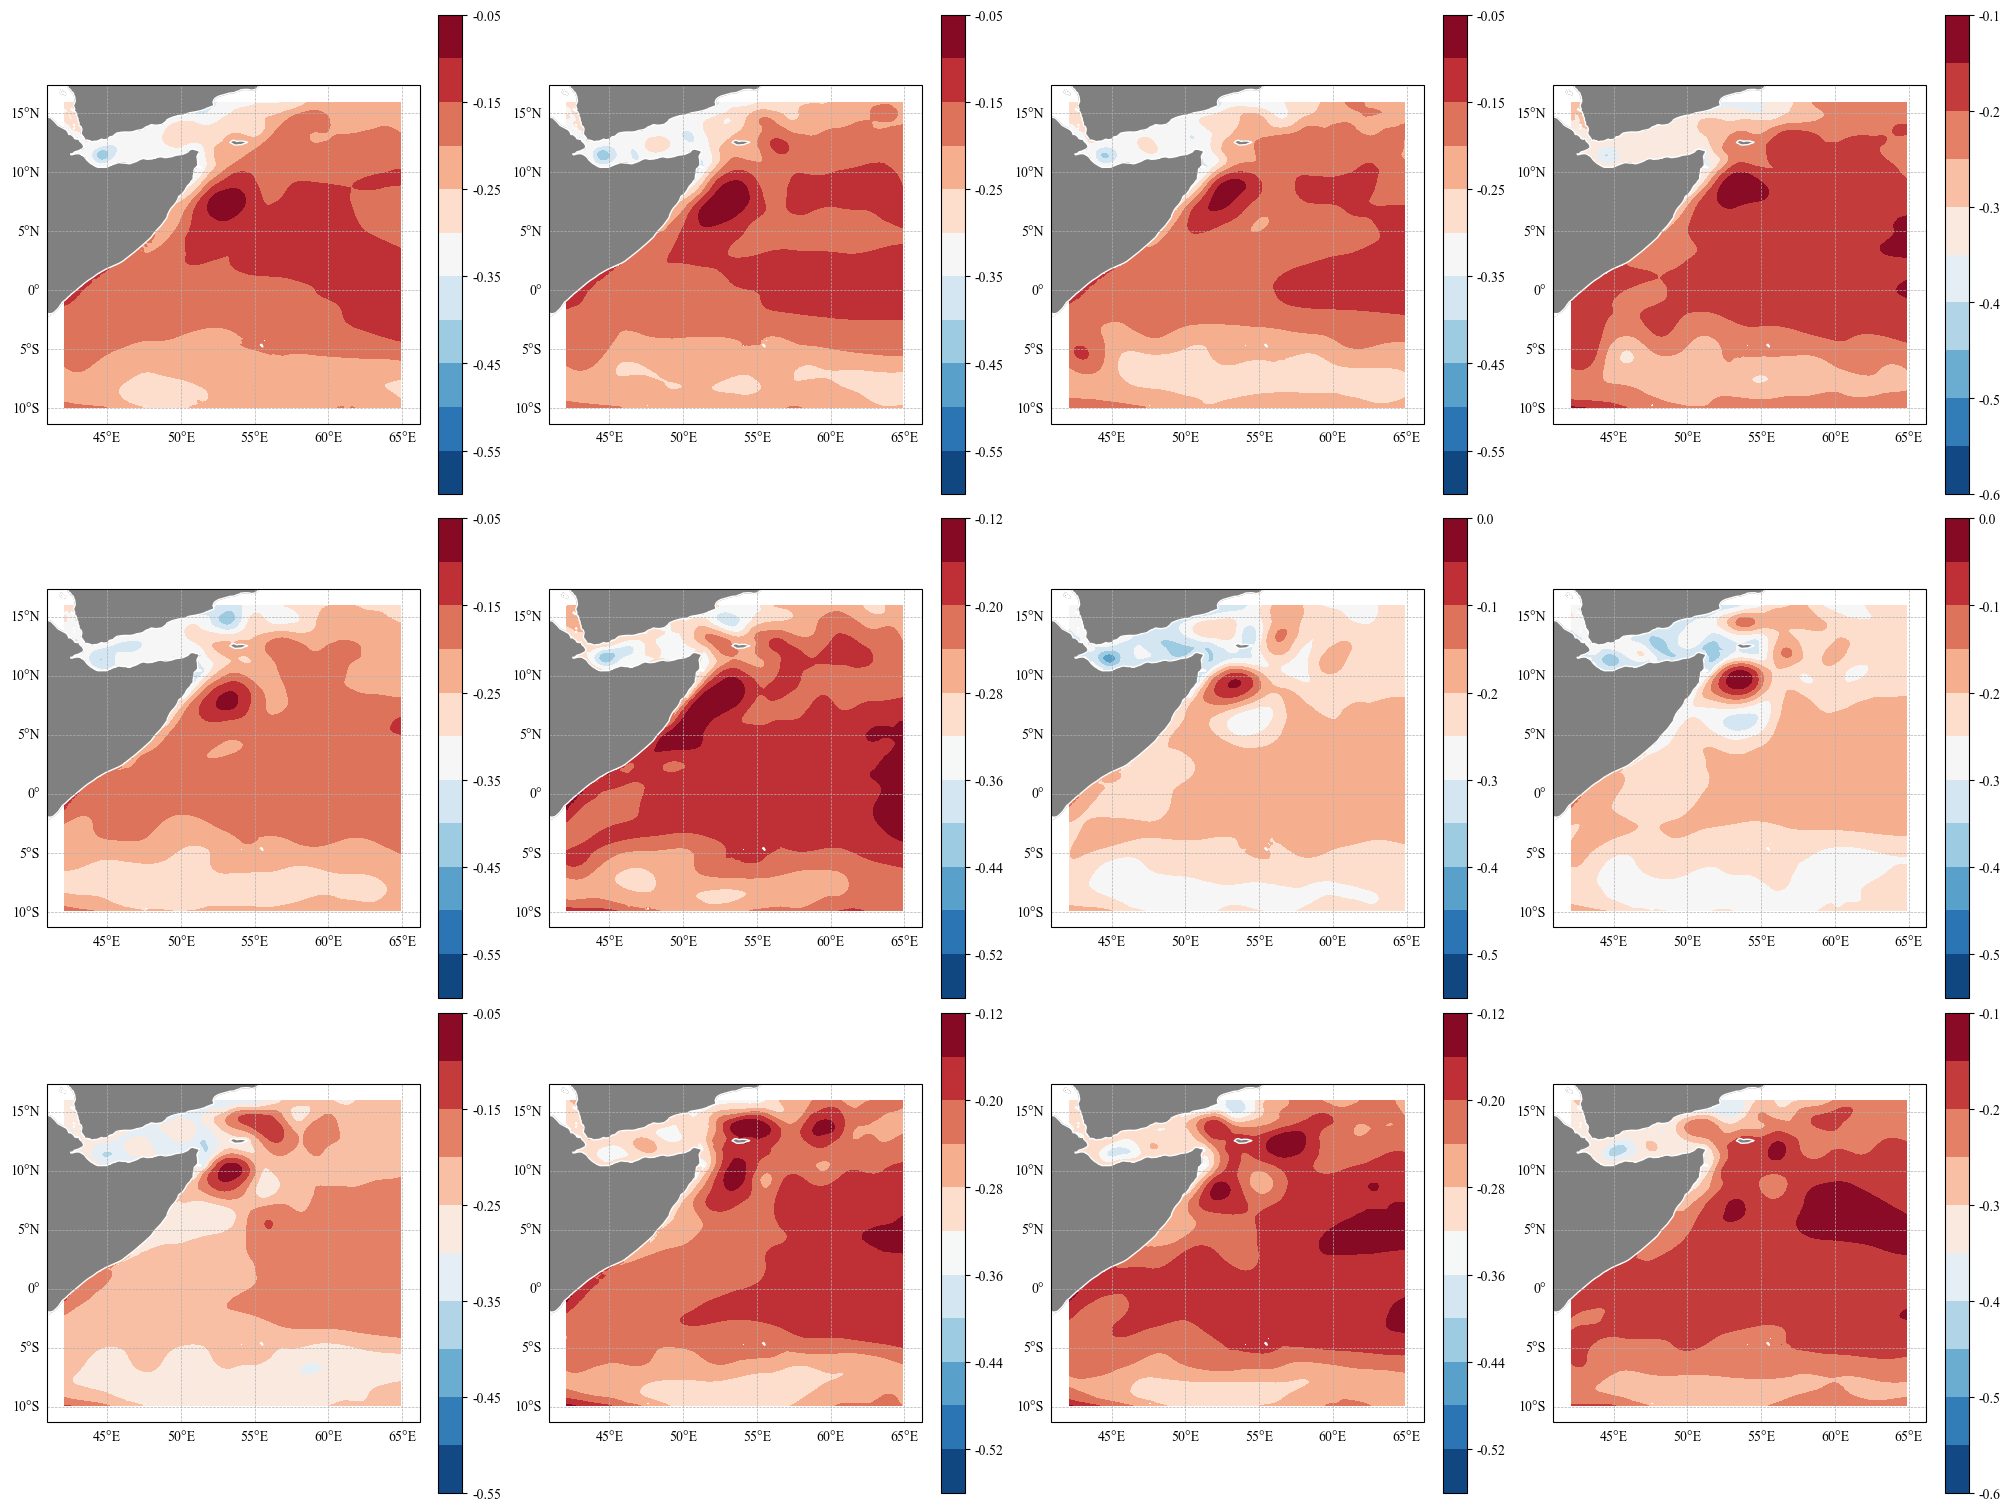

In [8]:
clim_model_SLA = xr.open_dataarray(r'D:\monthly_mean\model_SLA_data\model_clim_SLA.nc')
clim_AVISO_SLA = xr.open_dataarray(r'D:\AVISO_SLA_copernicusmarine\AVISO_SLA_data\AVISO_clim_SLA.nc')





# for month in range(1, 13):
#     levels = np.linspace(clim_model_SLA.sel(month=month).min().item(),
#                          clim_model_SLA.sel(month=month).max().item(),
#                          20)
#     a = clim_model_SLA.sel(month=month).plot.contourf(
#     ax=axes[month-1], 
#     x='lon', 
#     y='lat', 
#     cmap='RdBu_r', 
#     levels=levels
#     )

#     h = axes[month-1].contour(clim_AVISO_SLA.lon.values, clim_AVISO_SLA.lat.values,
#                               clim_AVISO_SLA.sel(month=month).values, transform=ccrs.PlateCarree(),
#                               levels=levels, colors='k')
    
#     axes[month-1].set_aspect(0.8)
#     axes[month-1].set_xticks([42, *np.arange(45, 65.1, 5)])
#     axes[month-1].set_yticks([*np.arange(-10, 15, 5), 16])
#     # axes[month-1].gridlines(draw_labels=True, linestyle='--', alpha=0.5)
#     axes[month-1].clabel(h, inline=True, fontsize=8, colors='k')
    


def plot_model_AVISO_SLA(model_data, AVISO_data, ax, levels):
    lon = model_data.lon.values
    lat = model_data.lat.values
    contourf = ax.contourf(lon, lat, model_data.values.T, 
                transform=ccrs.PlateCarree(), levels=levels, 
                cmap='RdBu_r')
    h = ax.contour(lon, lat, AVISO_data.values,
                   transform=ccrs.PlateCarree(), levels=levels, 
                   colors='k')
    ax.set_aspect(0.8)
    ax.add_feature(cfeature.LAND, color='gray')
    ax.add_feature(cfeature.COASTLINE, color='w')
    ax.clabel(h, inline=True, fontsize=8, colors='k')
    gl = ax.gridlines(draw_labels=True, lw=0.5, ls='--')
    gl.top_labels = False    # 隐藏顶部（北侧）标签
    gl.right_labels = False  # 隐藏右侧（东侧）标签
    # cbar = plt.colorbar(contourf, ticks=levels)
    cbar = plt.colorbar(contourf)

def plot_model_minus_AVISO(model_data, AVISO_data, ax):
    lon = model_data.lon.values
    lat = model_data.lat.values
    minus = model_data - AVISO_data
    contourf = ax.contourf(lon, lat, minus.values.T, 
                transform=ccrs.PlateCarree(), 
                levels=10, cmap='RdBu_r')
    ax.set_aspect(0.8)
    ax.add_feature(cfeature.LAND, color='gray')
    ax.add_feature(cfeature.COASTLINE, color='w')
    ax.clabel(h, inline=True, fontsize=8, colors='k')
    gl = ax.gridlines(draw_labels=True, lw=0.5, ls='--')
    gl.top_labels = False    # 隐藏顶部（北侧）标签
    gl.right_labels = False  # 隐藏右侧（东侧）标签
    # cbar = plt.colorbar(contourf, ticks=levels)
    cbar = plt.colorbar(contourf)


fig1, axes1 = plt.subplots(
    3, 4, 
    figsize=(20, 15), 
    subplot_kw=dict(projection=ccrs.PlateCarree()), 
    constrained_layout=True
)
axes1 = axes1.flatten()  

for month in range(1, 13):
    levels = np.linspace(clim_AVISO_SLA.sel(month=month).mean().item() - 12*clim_AVISO_SLA.sel(month=month).std().item(),
                         clim_AVISO_SLA.sel(month=month).mean().item() + 2*clim_AVISO_SLA.sel(month=month).std().item(),
                         10)
    plot_model_AVISO_SLA(clim_model_SLA.sel(month=month), clim_AVISO_SLA.sel(month=month), ax=axes1[month-1], levels=7)

plt.savefig(r'C:\Users\Admin\Desktop\eddy_figs\clim_model&AVISO.jpg', dpi=500)





fig2, axes2 = plt.subplots(
    3, 4, 
    figsize=(20, 15), 
    subplot_kw=dict(projection=ccrs.PlateCarree()), 
    constrained_layout=True
)
axes2 = axes2.flatten()  

for month in range(1, 13):
    plot_model_minus_AVISO(clim_model_SLA.sel(month=month), clim_AVISO_SLA.sel(month=month), ax=axes2[month-1])
plt.savefig(r'C:\Users\Admin\Desktop\eddy_figs\clim_model_minus_AVISO.jpg', dpi=500)

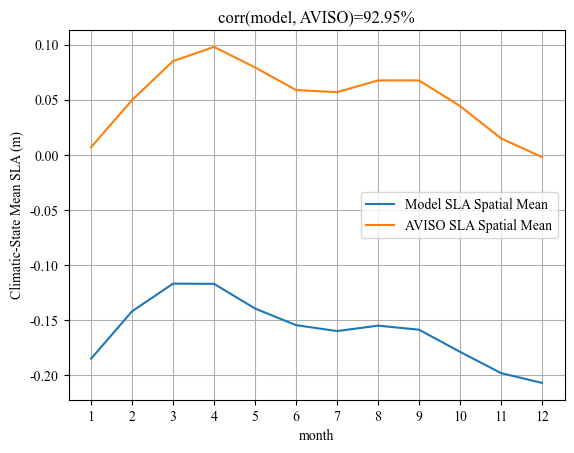

In [9]:
model_spatial_mean = clim_model_SLA.mean(dim=['lon', 'lat'])
AVISO_spatial_mean = clim_AVISO_SLA.mean(dim=['lon', 'lat'])
plt.plot(range(1, 13), model_spatial_mean, label='Model SLA Spatial Mean')
plt.plot(range(1, 13), AVISO_spatial_mean, label='AVISO SLA Spatial Mean')
plt.xticks(range(1, 13))
plt.xlabel('month')
plt.ylabel('Climatic-State Mean SLA (m)')
plt.title('corr(model, AVISO)=92.95%')
plt.grid()
plt.legend()
plt.savefig(r'C:\Users\Admin\Desktop\eddy_figs\clim_model_minus_AVISO_spatial_mean.jpg', dpi=500)